In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from calc_proj_NPCF_iso_direct import calc_NPCF
import time
import pickle
import sarabande
import os

plt.style.use("light_mode")


# Generate Data

In [2]:
nx = 256
data = np.zeros((nx,nx))
np.random.seed(7)

xs, ys, ws = [],[],[]
for x in range(nx):
    for y in range(nx):
        if np.random.randint(low=1, high=2000) == 50:
            data[x,y] = 1
            xs.append(x)
            ys.append(y)
            ws.append(1)
                

N_gal = len(np.where(data == 1)[0])               
print(f"There should be {len(np.where(data == 1)[0])} galaxies")
data_txt = np.array([xs, ys, ws]).T   

There should be 41 galaxies


In [320]:
#save data
np.savetxt("direct_input_data/simple_data_proj.txt", data_txt)

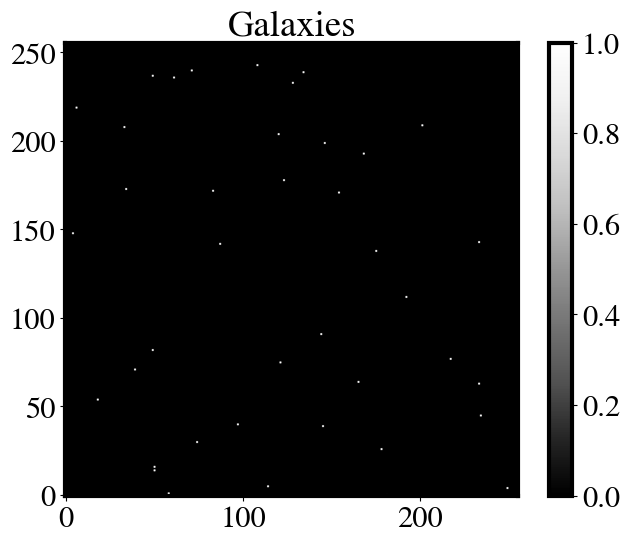

In [4]:
plt.figure(figsize=(8,6))
plt.title("Galaxies")
plt.imshow(data[:,:], origin="lower", cmap="Greys_r",vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Proj 3PCF

### Run Direct Code

In [6]:
start_time = time.time()

npcf = 3
nbins = 10
lbox = nx
rmax = lbox/2
verbose=False

zetas = calc_NPCF(npcf, data_txt, nbins, lbox, rmax, lls=None, verbose=verbose)
zetas.init_coeff()
zetas.run()
sdir = "direct_results/"
sname1 = sdir+f"simple_coeff_{npcf}pcf_nbins{nbins}_lbox{lbox}_rmax{rmax}"
zetas.save(sname1)
 
elapsed_time = time.time() - start_time
print(f"number of galaxies: {data_txt.shape[0]:1d}")
print(f"elapsed time: {elapsed_time:.3f} s")

no shift executed because in genuine box
>> save file to simple_coeff_3pcf_nbins10_lbox256_rmax128.0.pkl
number of galaxies: 41
elapsed time: 2.574 s


In [7]:

zeta_direct = pickle.load(open(f"direct_results/simple_coeff_{npcf}pcf_nbins{nbins}_lbox{lbox}_rmax{rmax}.pkl", "rb"))

for ll in zeta_direct.keys():
    # zeta_direct[ll] *= 1./(4 * np.pi)
    for bin1 in range(0, nbins, 1):
        for bin2 in range(bin1): #?? for bin2 in range(0, bin2<=bin1, 1):
            # norm = A_bin[bin1] * A_bin[bin2] * N_gal * nbar**2
            norm = 1
            zeta_direct[ll][bin1, bin2] /= norm
            zeta_direct[ll][bin2, bin1] = zeta_direct[ll][bin1, bin2]

### Run Sarabande Code

In [9]:
#string to directory to save data into
save_dir = os.getcwd() + '/output/'

#create measure_obj
proj_3PCF = sarabande.measure(nPCF=3, projected=True, m_max=4, density_field_data = data,
                                   save_dir=save_dir, save_name='example', nbins=nbins,
                                   physical_boxsize=lbox, rmin=1e-14, rmax=rmax, 
                                   normalize=False, particles_on_grid=True)

sarabande.calc_zeta(proj_3PCF)

Preparing the data:
Creating Radial Bins ... 

Creating kernels ... 

taking the fourier transform of data ... 

calculating C_m Coefficients ... 

Starting Calculation of Projected 3PCF.

Finished Calculating the Projected 3PCF in 0.4250 seconds


In [10]:
bins = np.linspace(1, rmax, nbins)
average_bins= []
for i in range(len(bins)):
    if i >= 1:
        b_i = (bins[i] + bins[i-1]) /2 
    elif i == 0:
        b_i = bins[i]/2
        
    average_bins.append(b_i)
    
average_bins = np.array(average_bins)

def calc_sawtooth(zeta, l, direct):
    
    if direct == True:
        zeta_l_1d, bin_indexes, b_i = [], [], 0
        for b1 in range(0,nbins):
            for b2 in range(b1, nbins):
                value = zeta[l][b1,b2]
                # value *= average_bins[b1] * average_bins[b2]
                zeta_l_1d.append(value)
                bin_indexes.append(b_i)
                b_i += 1
                
    else:
        zeta_l_1d, bin_indexes, b_i = [], [], 0
        for b1 in range(0,nbins):
            for b2 in range(b1, nbins):
                value = zeta[l,b1,b2]
                # value *= average_bins[b1] * average_bins[b2]
                zeta_l_1d.append(value)
                bin_indexes.append(b_i)
                b_i += 1
                
    bin_indexes = np.array(bin_indexes)
    zeta_l_1d = np.array(zeta_l_1d)
    return bin_indexes, zeta_l_1d

In [12]:
m = 2
m_val_string = str(m)


sarabande_bins_not_normalized, zeta_1d_sarabande_not_normalized = calc_sawtooth(proj_3PCF.zeta, m, direct=False)
direct_bins_not_normalized, zeta_1d_direct_not_normalized = calc_sawtooth(zeta_direct, m_val_string, direct=True)

sarabande_bins_3PCF_not_normalized, zeta_1d_sarabande_3PCF_not_normalized = sarabande_bins_not_normalized, zeta_1d_sarabande_not_normalized
direct_bins_3PCF_not_normalized, zeta_1d_direct_3PCF_not_normalized = direct_bins_not_normalized, zeta_1d_direct_not_normalized

In [13]:
zeta_direct = pickle.load(open(f"direct_results/simple_coeff_{npcf}pcf_nbins{nbins}_lbox{lbox}_rmax{rmax}.pkl", "rb"))

rmin = 0

n_r = nbins
r_arr = np.linspace(rmin,rmax,n_r+1)
r_lo = r_arr[:-1]
r_hi = r_arr[1:]
r_av = 0.5*(r_lo+r_hi)
A_bin = np.pi*(r_hi**2.-r_lo**2.)

nbar = N_gal / (lbox**2)

for ll in zeta_direct.keys():
    # zeta_direct[ll] *= 1./(4 * np.pi)
    for bin1 in range(0, nbins, 1):
        for bin2 in range(bin1): #?? for bin2 in range(0, bin2<=bin1, 1):
            norm = A_bin[bin1] * A_bin[bin2] * N_gal * nbar**2
            zeta_direct[ll][bin1, bin2] /= norm
            zeta_direct[ll][bin2, bin1] = zeta_direct[ll][bin1, bin2]

In [14]:
#string to directory to save data into
save_dir = os.getcwd() + '/output/'

#create measure_obj
proj_3PCF = sarabande.measure(nPCF=3, projected=True, m_max=4, density_field_data = data,
                                   save_dir=save_dir, save_name='example', nbins=nbins,
                                   physical_boxsize=lbox, rmin=1e-14, rmax=rmax, 
                                   normalize=True, particles_on_grid=True)

sarabande.calc_zeta(proj_3PCF)

Preparing the data:
Creating Radial Bins ... 

Creating kernels ... 

taking the fourier transform of data ... 

calculating C_m Coefficients ... 

Starting Calculation of Projected 3PCF.

Finished Calculating the Projected 3PCF in 0.4282 seconds


In [15]:
m = 2
m_val_string = str(m)


sarabande_bins_normalized, zeta_1d_sarabande_normalized = calc_sawtooth(proj_3PCF.zeta, m, direct=False)
direct_bins_normalized, zeta_1d_direct_normalized = calc_sawtooth(zeta_direct, m_val_string, direct=True)

sarabande_bins_3PCF_normalized, zeta_1d_sarabande_3PCF_normalized = sarabande_bins_normalized, zeta_1d_sarabande_normalized
direct_bins_3PCF_normalized, zeta_1d_direct_3PCF_normalized = direct_bins_normalized, zeta_1d_direct_normalized

# Proj 4PCF

### Run Direct Code

In [67]:
start_time = time.time()

npcf = 4
nbins = 10
lbox = nx
rmax = lbox / 2
verbose=False

zetas = calc_NPCF(npcf, data_txt, nbins, lbox, rmax, lls=None, verbose=verbose)
zetas.init_coeff()
zetas.run()
sdir = "direct_results/"
sname1 = sdir+f"simple_coeff_{npcf}pcf_nbins{nbins}_lbox{lbox}_rmax{rmax}"
zetas.save(sname1)
 
elapsed_time = time.time() - start_time
print(f"number of galaxies: {data_txt.shape[0]:1d}")
print(f"elapsed time: {elapsed_time:.3f} s")

no shift executed because in genuine box
>> save file to simple_coeff_4pcf_nbins10_lbox256_rmax128.0.pkl
number of galaxies: 41
elapsed time: 86.018 s


In [68]:
zeta_direct = pickle.load(open(f"direct_results/simple_coeff_{npcf}pcf_nbins{nbins}_lbox{lbox}_rmax{rmax}.pkl", "rb"))

rmin = 0

n_r = nbins
r_arr = np.linspace(rmin,rmax,n_r+1)
r_lo = r_arr[:-1]
r_hi = r_arr[1:]
r_av = 0.5*(r_lo+r_hi)
A_bin = np.pi*(r_hi**2.-r_lo**2.)

nbar = N_gal / (lbox**2)

for mm in zeta_direct.keys():
    # zeta_direct[ll] *= 1./(4 * np.pi)
    for bin1 in range(nbins):
        for bin2 in range(bin1):
            for bin3 in range(bin2):
                norm = A_bin[bin1] * A_bin[bin2] * A_bin[bin3] * N_gal * nbar**3
                norm = 1
                zeta_direct[mm][bin1, bin2, bin3] /= norm
                zeta_direct[mm][bin3, bin1, bin2] = zeta_direct[mm][bin1, bin2, bin3]
                zeta_direct[mm][bin2, bin3, bin1] = zeta_direct[mm][bin1, bin2, bin3]
                zeta_direct[mm][bin1, bin3, bin2] = zeta_direct[mm][bin1, bin2, bin3]
                zeta_direct[mm][bin2, bin1, bin3] = zeta_direct[mm][bin1, bin2, bin3]
                zeta_direct[mm][bin3, bin2, bin1] = zeta_direct[mm][bin1, bin2, bin3]
                # print(f"m1,m2 = {mm}   \t& \tb1,b2,b3 = {bin1}, {bin2}, {bin3}")

### Run Sarabande Code

In [70]:
#string to directory to save data into
save_dir = os.getcwd() + '/output/'

#create measure_obj
proj_4PCF = sarabande.measure(nPCF=4, projected=True, m_max=12, density_field_data = data,
                                   save_dir=save_dir, save_name='example', nbins=nbins,
                                   physical_boxsize=lbox, rmin=1e-14, rmax=rmax, normalize=False,
                                    particles_on_grid=True)

sarabande.calc_zeta(proj_4PCF)

Preparing the data:
Creating Radial Bins ... 

Creating kernels ... 

taking the fourier transform of data ... 

calculating C_m Coefficients ... 

Starting Calculation of Projected 4PCF.

Finished Calculating the Projected 4PCF in 33.4354 seconds


In [71]:
bins = np.linspace(1, rmax, nbins)
average_bins= []
for i in range(len(bins)):
    if i >= 1:
        b_i = (bins[i] + bins[i-1]) /2 
    elif i == 0:
        b_i = bins[i]/2
        
    average_bins.append(b_i)
    
average_bins = np.array(average_bins)

def calc_sawtooth(zeta, m_vals, direct):
    
    if direct == True:
   
        zeta_l_1d, bin_indexes, b_i = [], [], 0
        for b1 in range(0,nbins):
            for b2 in range(b1+1, nbins):
                for b3 in range(b2+1, nbins):
                    value = zeta[m_vals][b1,b2,b3]
                    # value *= average_bins[b1] * average_bins[b2] * average_bins[b3]
                    zeta_l_1d.append(value)
                    bin_indexes.append(b_i)
                    b_i += 1
                
    else:
        m_1, m_2 = int(m_vals[0]),int(m_vals[1])
        zeta_l_1d, bin_indexes, b_i = [], [], 0
        for b1 in range(0,nbins):
            for b2 in range(b1+1, nbins):
                for b3 in range(b2+1, nbins):
                    value = zeta[m_1,m_2,b1,b2,b3]
                    # value *= average_bins[b1] * average_bins[b2] * average_bins[b3]
                    zeta_l_1d.append(value)
                    bin_indexes.append(b_i)
                    b_i += 1
                
    bin_indexes = np.array(bin_indexes)
    zeta_l_1d = np.array(zeta_l_1d)
    return bin_indexes, zeta_l_1d

In [72]:
m_val_string = "22"

sarabande_bins_not_normalized, zeta_1d_sarabande_not_normalized = calc_sawtooth(proj_4PCF.zeta, m_val_string, direct=False)
direct_bins_not_normalized, zeta_1d_direct_not_normalized = calc_sawtooth(zeta_direct, m_val_string, direct=True)

sarabande_bins_4PCF_not_normalized, zeta_1d_sarabande_4PCF_not_normalized = sarabande_bins_not_normalized, zeta_1d_sarabande_not_normalized
direct_bins_4PCF_not_normalized, zeta_1d_direct_4PCF_not_normalized = direct_bins_not_normalized, zeta_1d_direct_not_normalized

In [73]:
zeta_direct = pickle.load(open(f"direct_results/simple_coeff_{npcf}pcf_nbins{nbins}_lbox{lbox}_rmax{rmax}.pkl", "rb"))

rmin = 0

n_r = nbins
r_arr = np.linspace(rmin,rmax,n_r+1)
r_lo = r_arr[:-1]
r_hi = r_arr[1:]
r_av = 0.5*(r_lo+r_hi)
A_bin = np.pi*(r_hi**2.-r_lo**2.)

nbar = N_gal / (lbox**2)

for mm in zeta_direct.keys():
    # zeta_direct[ll] *= 1./(4 * np.pi)
    for bin1 in range(nbins):
        for bin2 in range(bin1):
            for bin3 in range(bin2):
                norm = A_bin[bin1] * A_bin[bin2] * A_bin[bin3] * N_gal * nbar**3
                # norm = 1
                zeta_direct[mm][bin1, bin2, bin3] /= norm
                zeta_direct[mm][bin3, bin1, bin2] = zeta_direct[mm][bin1, bin2, bin3]
                zeta_direct[mm][bin2, bin3, bin1] = zeta_direct[mm][bin1, bin2, bin3]
                zeta_direct[mm][bin1, bin3, bin2] = zeta_direct[mm][bin1, bin2, bin3]
                zeta_direct[mm][bin2, bin1, bin3] = zeta_direct[mm][bin1, bin2, bin3]
                zeta_direct[mm][bin3, bin2, bin1] = zeta_direct[mm][bin1, bin2, bin3]
                # print(f"m1,m2 = {mm}   \t& \tb1,b2,b3 = {bin1}, {bin2}, {bin3}")

In [74]:
#string to directory to save data into
save_dir = os.getcwd() + '/output/'

#create measure_obj
proj_4PCF = sarabande.measure(nPCF=4, projected=True, m_max=12, density_field_data = data,
                                   save_dir=save_dir, save_name='example', nbins=nbins,
                                   physical_boxsize=lbox, rmin=1e-14, rmax=rmax, normalize=True,
                                    particles_on_grid=True)

sarabande.calc_zeta(proj_4PCF)

Preparing the data:
Creating Radial Bins ... 

Creating kernels ... 

taking the fourier transform of data ... 

calculating C_m Coefficients ... 

Starting Calculation of Projected 4PCF.

Finished Calculating the Projected 4PCF in 30.6965 seconds


In [75]:
m_val_string = "22"

sarabande_bins_normalized, zeta_1d_sarabande_normalized = calc_sawtooth(proj_4PCF.zeta, m_val_string, direct=False)
direct_bins_normalized, zeta_1d_direct_normalized = calc_sawtooth(zeta_direct, m_val_string, direct=True)

sarabande_bins_4PCF_normalized, zeta_1d_sarabande_4PCF_normalized = sarabande_bins_normalized, zeta_1d_sarabande_normalized
direct_bins_4PCF_normalized, zeta_1d_direct_4PCF_normalized = direct_bins_normalized, zeta_1d_direct_normalized

# 1D Bin Data

In [321]:
b1s_4pcf, b2s_4pcf, b3s_4pcf, bin_indexes_4pcf, b_i_4pcf = [], [], [], [], 0
for b1 in range(0,nbins):
    for b2 in range(b1+1, nbins):
        for b3 in range(b2+1, nbins):
            b1s_4pcf.append(b1)
            b2s_4pcf.append(b2)
            b3s_4pcf.append(b3)
            bin_indexes_4pcf.append(b_i_4pcf)
            b_i_4pcf += 1
            
            
b1s_3pcf, b2s_3pcf, bin_indexes_3pcf, b_i_3pcf = [], [], [], 0
for b1 in range(0,nbins):
    for b2 in range(b1+1, nbins):
        b1s_3pcf.append(b1)
        b2s_3pcf.append(b2)
        bin_indexes_3pcf.append(b_i_3pcf)
        b_i_3pcf += 1

In [322]:
normalized_sarabande_3PCF_data = [sarabande_bins_3PCF_normalized, zeta_1d_sarabande_3PCF_normalized]
normalized_DC_3PCF_data = [direct_bins_3PCF_normalized, zeta_1d_direct_3PCF_normalized]
    
not_normalized_sarabande_3PCF_data = [sarabande_bins_3PCF_not_normalized, zeta_1d_sarabande_3PCF_not_normalized]
not_normalized_DC_3PCF_data = [direct_bins_3PCF_not_normalized, zeta_1d_direct_3PCF_not_normalized]



normalized_sarabande_4PCF_data = [sarabande_bins_4PCF_normalized, zeta_1d_sarabande_4PCF_normalized]
normalized_DC_4PCF_data = [direct_bins_4PCF_normalized, zeta_1d_direct_4PCF_normalized]
    
not_normalized_sarabande_4PCF_data = [sarabande_bins_4PCF_not_normalized, zeta_1d_sarabande_4PCF_not_normalized]
not_normalized_DC_4PCF_data = [direct_bins_4PCF_not_normalized, zeta_1d_direct_4PCF_not_normalized]


# Final Figure

In [355]:
def create_NPCF_plot(ax_center, 
                     NPCF, 
                     sarabande_data, DC_data,
                     offset_center, residual_factor,
                     c_bounds_l,c_bounds_r,
                     normalized, 
                     legend,
                     size="20%", pad=0):
    
    """
    ax_center: ax object
    NPCF: Int 3 or 4 for 3/4 PCF
    sarabande_data, DC_data: lists with [x_data, y_data]
    offset_center: how much we offset Re & Im parts
    residual_factor: factor we multiply residuals by to scale them by (14 -> R x 1e14)
    c_bounds_l,c_bounds_r: lower and upper bounds for center axis
    normalized: bool to indicate if the coefficients are normalized
    legend: bool to indicate if a legend is desired
    size: percentage string indicating the size of the residual axis
    pad: spacing between the center and residual axes
    
    """
    
    #divide the axes into two
    divider = make_axes_locatable(ax_center)
    ax_bottom = divider.append_axes("bottom", size=size, pad=pad)
    ax_center.figure.add_axes(ax_bottom)
    
    #format data
    sarabande_bins, zeta_1d_sarabande = sarabande_data
    direct_bins, zeta_1d_direct = DC_data
    
    #center plot
    
    # -----> labels & titles
    
    if normalized:
        ax_center.set_title("After Normalization", pad = 10)
    else:
        ax_center.set_title("Before Normalization", pad = 10)
        
    if NPCF == 3:
        ax_center.set_ylabel("$\\hat{\zeta}^{\mathrm{ \; b_1 b_2}}_{m} \pm$ Offset",fontsize=26)
    elif NPCF == 4:
        ax_center.set_ylabel("$\\hat{\zeta}^{\mathrm{ \; b_1 b_2 b_3}}_{m_1 m_2} \pm$ Offset",
                             fontsize=26)

    # -----> plotting data
    
    lw = 4
    
    ax_center.plot(sarabande_bins, zeta_1d_sarabande.real + offset_center,
                   color="red", linestyle="-", linewidth=lw,label="Re[Sarabande]")
    
    ax_center.plot(direct_bins, zeta_1d_direct.real + offset_center,
                   color="black", linestyle=":", linewidth=lw, label="Re[DC]")
    
    ax_center.plot(sarabande_bins, zeta_1d_sarabande.imag - offset_center,
                   color="dodgerblue", linestyle="-", linewidth=lw,label="Im[Sarabande]")
    
    ax_center.plot(direct_bins, zeta_1d_direct.imag - offset_center,
                   color="black", linestyle="dashdot", linewidth=lw, label="Im[DC]")

    # -----> bounds
    ax_center.set_xlim(0,len(direct_bins)-1)
    ax_center.set_ylim(c_bounds_l,c_bounds_r)
    
    # -----> grid & legend
    ax_center.set_xticklabels([])
    ax_center.grid()
    
    if legend:
        ax_center.legend(shadow=True, edgecolor="black", ncol=2, fontsize=18)
    
    #residual plot
    
    factor = 10**residual_factor
    
    ax_bottom.plot(direct_bins, 
                   (zeta_1d_sarabande.imag - zeta_1d_direct.imag) * factor,
                    color="blue",linestyle="-", linewidth=lw)
    
    ax_bottom.plot(direct_bins, 
                   (zeta_1d_sarabande.real - zeta_1d_direct.real) * factor,
                    color="red",linestyle="--", linewidth=lw)
    
    
    ax_bottom.set_ylim(-4,4)
    ax_bottom.set_xlim(0,len(direct_bins)-1)
    label_str = "Residuals \n $\\times 10^{-" + str(residual_factor) + "}$"
    ax_bottom.set_ylabel(label_str)
    ax_bottom.set_xlabel("Bin Index", fontsize=26)
    ax_bottom.grid()
    
    # ------------------------------

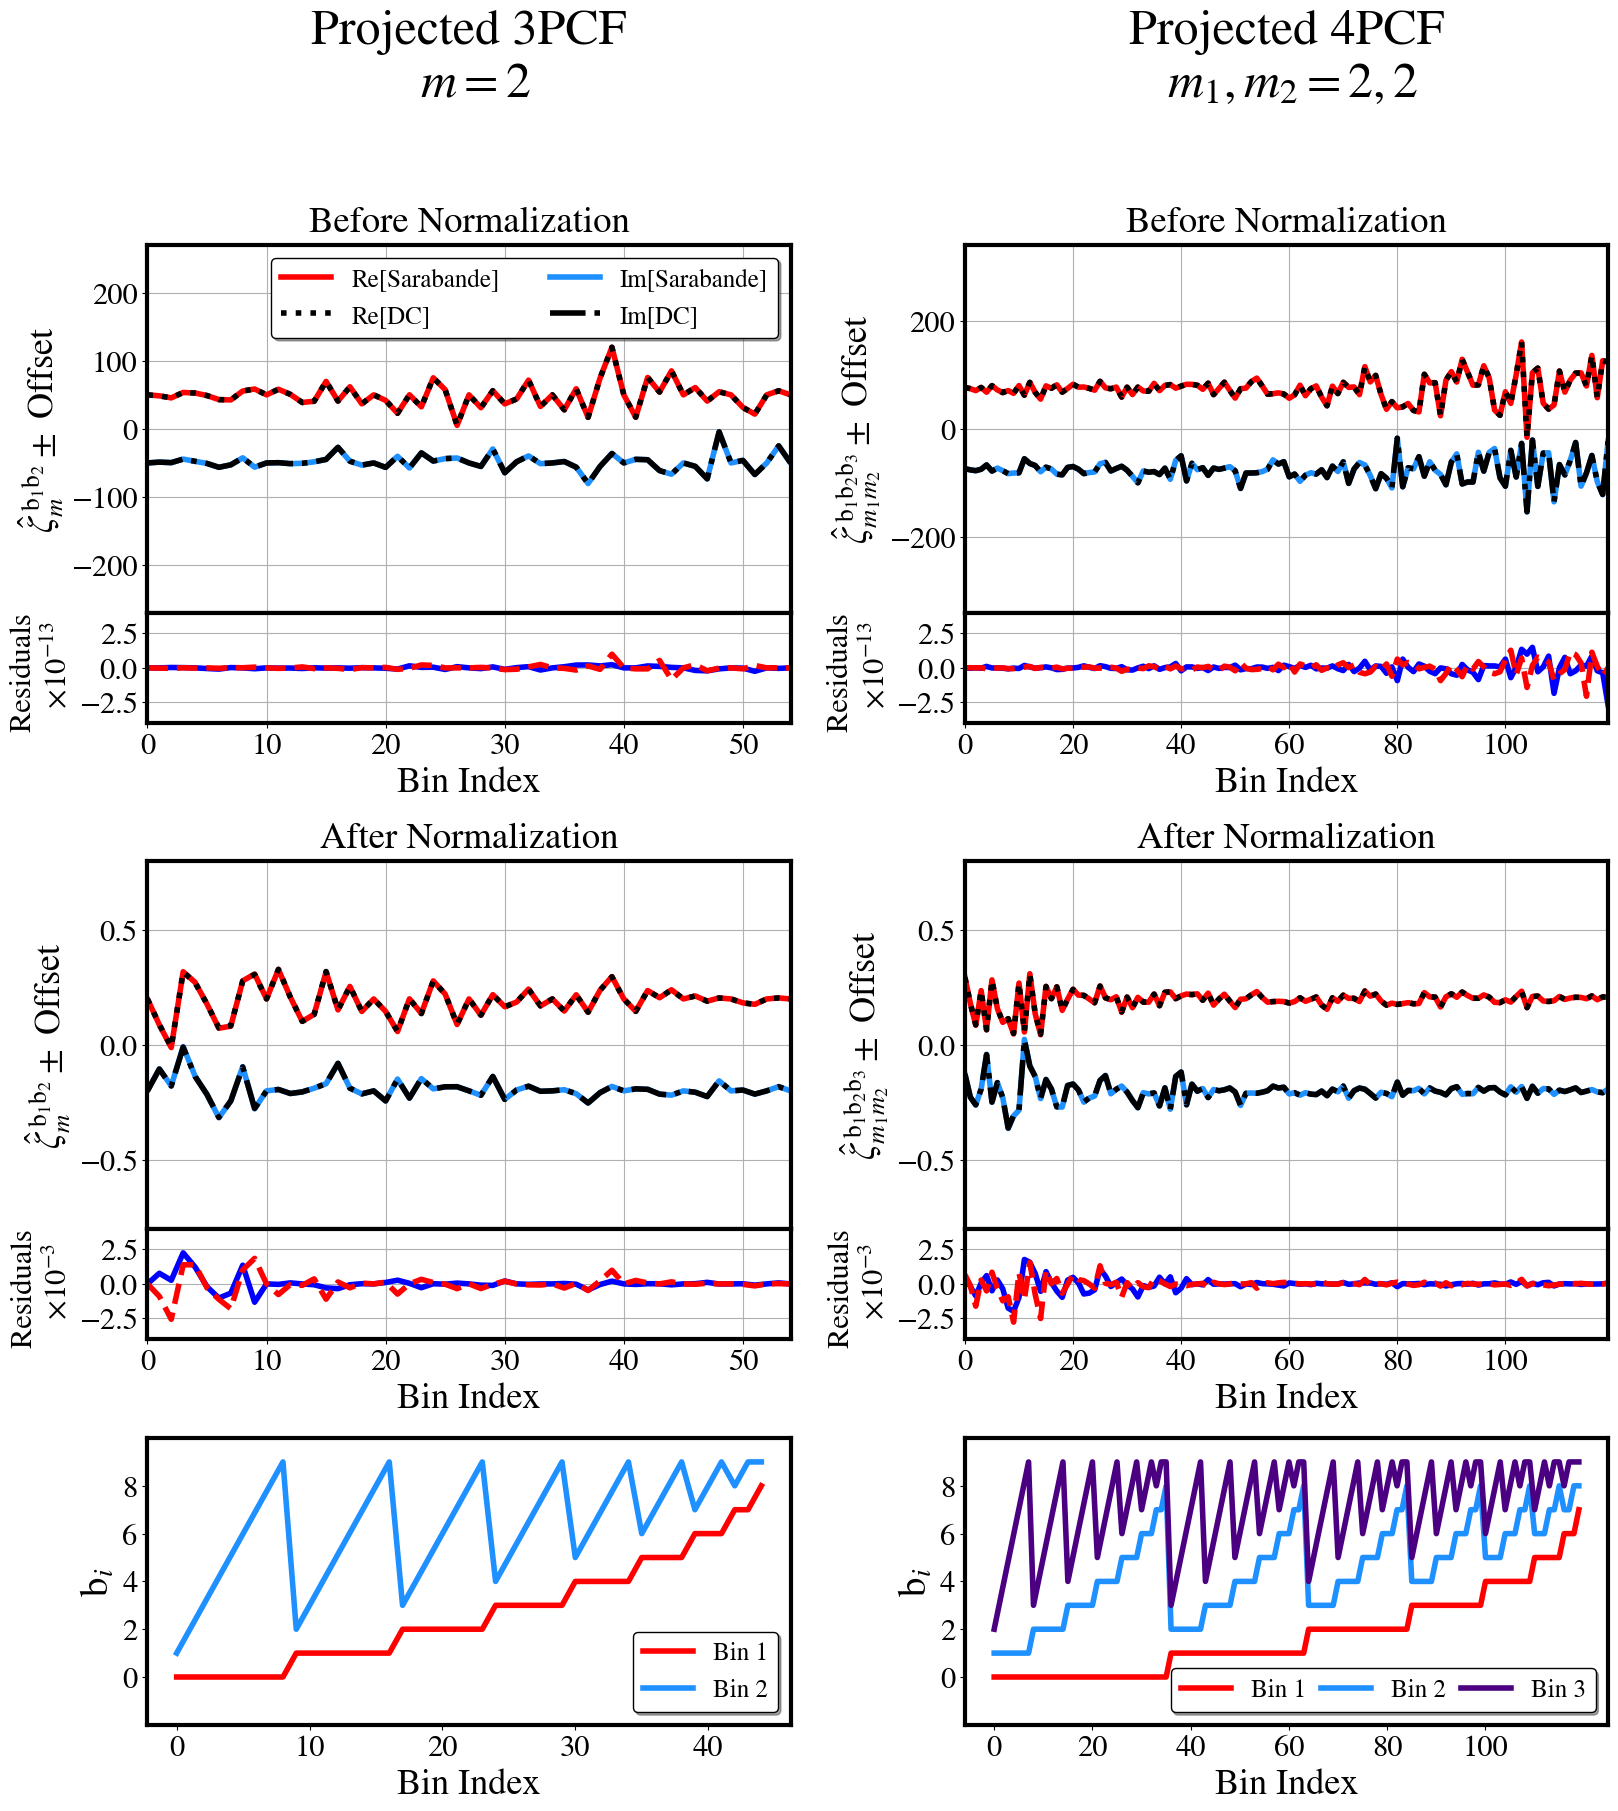

In [358]:
fig, axes = plt.subplots(nrows=3 + 1, ncols=2, figsize=(16,18), constrained_layout=True, 
                         gridspec_kw={"height_ratios":[0.000001,1,1,0.6], "hspace":0.22, "wspace":0.05})
                                                                            

create_NPCF_plot(axes[1,0], 3,
                 not_normalized_sarabande_3PCF_data, not_normalized_DC_3PCF_data,
                 offset_center = 50, residual_factor = 13,
                 c_bounds_l = -2.7e2,c_bounds_r = 2.7e2,
                 normalized = False,
                 legend = True,
                 size="30%")

create_NPCF_plot(axes[2,0], 3,
                 normalized_sarabande_3PCF_data, normalized_DC_3PCF_data,
                 offset_center = 0.2, residual_factor = 3,
                 c_bounds_l = -0.8e0,c_bounds_r = 0.8e0,
                 normalized = True,
                 legend = False,
                 size="30%")

create_NPCF_plot(axes[1,1], 4,
                 not_normalized_sarabande_4PCF_data, not_normalized_DC_4PCF_data,
                 offset_center = 75, residual_factor = 13,
                 c_bounds_l = -3.4e2,c_bounds_r = 3.4e2,
                 normalized = False,
                 legend = False,
                 size="30%")

create_NPCF_plot(axes[2,1], 4,
                 normalized_sarabande_4PCF_data, normalized_DC_4PCF_data,
                 offset_center = 0.2, residual_factor = 3,
                 c_bounds_l = -0.8e0,c_bounds_r = 0.8e0,
                 normalized = True,
                 legend = False,
                 size="30%")

    
axes[3,0].plot(bin_indexes_3pcf, b1s_3pcf, marker=" ", markersize=3, linestyle="-", linewidth=4, color="red", label="Bin 1")
axes[3,0].plot(bin_indexes_3pcf, b2s_3pcf, marker=" ", markersize=3, linestyle="-", linewidth=4, color="dodgerblue", label="Bin 2")
axes[3,0].set_xlabel("Bin Index",fontsize=26)
axes[3,0].set_ylabel("$\mathrm{b}_i$",fontsize=28)
axes[3,0].set_yticks([0,2,4,6,8])
axes[3,0].legend(shadow=True, edgecolor="black", fontsize=18)
axes[3,0].set_ylim(-2,10)


axes[3,1].plot(bin_indexes_4pcf, b1s_4pcf, marker=" ", markersize=3, linestyle="-", linewidth=4, color="red", label="Bin 1")
axes[3,1].plot(bin_indexes_4pcf, b2s_4pcf, marker=" ", markersize=3, linestyle="-", linewidth=4, color="dodgerblue", label="Bin 2")
axes[3,1].plot(bin_indexes_4pcf, b3s_4pcf, marker=" ", markersize=3, linestyle="-", linewidth=4, color="indigo", label="Bin 3")
axes[3,1].set_xlabel("Bin Index",fontsize=26)
axes[3,1].set_ylabel("$\mathrm{b}_i$",fontsize=28)
axes[3,1].set_yticks([0,2,4,6,8])
axes[3,1].set_xticks([0, 20,40, 60,80, 100])
axes[3,1].set_ylim(-2,10)

axes[3,1].legend(shadow=True, ncol=3, loc="lower right",
                 edgecolor="black",columnspacing=0.6, fontsize=18)

axes[0,0].axis("off")
axes[0,0].set_title(f"Projected 3PCF\n $m = {m}$", fontsize=36)
axes[0,1].axis("off")
axes[0,1].set_title(f"Projected 4PCF\n $m_1, m_2 = {m_1}, {m_2}$", fontsize=36)

# plt.tight_layout()  
# plt.savefig("Normalization_comparison_figure.pdf", dpi = 300, bbox_inches="tight")
plt.show()

